In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r '/content/drive/MyDrive/full_3/full_3' 'documents'

In [3]:
!pip install -U keras
!pip install tensorflow
!sudo apt install tesseract-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
te

In [4]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.optimizers import SGD
import os
from PIL import Image
import pytesseract
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50

Leitura de dados

In [6]:
path_documents = 'documents'
lista_subfolders = os.listdir(path_documents)

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
    lista_imagens = os.listdir(path_documents+'/'+folder)

    for img_file in lista_imagens:
        dataset_dict['filename'].append(folder + '/' + img_file)
        dataset_dict['label'].append(folder)

In [7]:
df = pd.DataFrame(dataset_dict,columns=['filename','label'])

In [8]:
X = df['filename'].values
Y = df['label'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test,test_size=0.7,random_state=42)

Criação dos Logits dos labels

In [10]:
train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)

y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int =  test_labels.codes

y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

In [11]:
lista_train = []
for i in range(0,len(X_train)):
    lista_train.append([X_train[i],y_train[i]])

lista_valid = []
for i in range(0,len(X_valid)):
    lista_valid.append([X_valid[i],y_valid[i]])

lista_test = []
for i in range(0,len(X_test)):
    lista_test.append([X_test[i],y_test[i]])

In [12]:
df_train = pd.DataFrame(lista_train,columns = ['filename','label'])
df_valid = pd.DataFrame(lista_valid,columns = ['filename','label'])
df_test = pd.DataFrame(lista_test,columns = ['filename','label'])

In [13]:
df_train

,filename,label
0,email/2084390683a.tif,email
1,email/2071862778a.tif,email
2,advertisement/71896575.tif,advertisement
3,scientific _publication/60046777_60046785.tif,scientific _publication
4,scientific _publication/1240.tif,scientific _publication
...,...,...
2069,email/2085272065.tif,email
2070,email/2080891376a.tif,email
2071,email/2064833034.tif,email
2072,email/1041.tif,email


In [14]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename', y_col='label',
                                              class_mode='categorical')

valid_generator = datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

test_generator = datagen.flow_from_dataframe(df_test,
                                              directory=path_documents,
                                              x_col='filename', y_col='label',
                                              class_mode='categorical')

Found 2072 validated image filenames belonging to 3 classes.
Found 267 validated image filenames belonging to 3 classes.
Found 622 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [15]:
dims = (224,224,3)
num_classes = 3

In [16]:
model = Sequential()
model.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model.add(Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=dims))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(5,5), strides=1, padding='same', activation='relu', input_shape=dims))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(384, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', input_shape=dims))
model.add(Dropout(0.5))
model.add(Conv2D(384, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', input_shape=dims))
model.add(Conv2D(384, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', input_shape=dims))
model.add(MaxPooling2D((3, 3), strides=(2, 2)))
model.add(Flatten())

model.add(Dense(4096, activation='relu'))

model.add(Dense(4096, activation='relu'))

model.add(Dense(num_classes, activation = 'softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0

In [18]:
sgd = SGD(learning_rate=0.00001)

model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine = model.fit(train_generator,
                        epochs=20,
                        batch_size=16,
                        validation_data=valid_generator)

Epoch 1/20
65/65 [==============================] - 33s 305ms/step - loss: 1.1834 - accuracy: 0.3069 - val_loss: 1.0981 - val_accuracy: 0.3783
Epoch 2/20
65/65 [==============================] - 10s 160ms/step - loss: 1.0528 - accuracy: 0.3427 - val_loss: 1.0935 - val_accuracy: 0.3745
Epoch 3/20
65/65 [==============================] - 10s 158ms/step - loss: 1.0138 - accuracy: 0.3851 - val_loss: 1.0863 - val_accuracy: 0.3670
Epoch 4/20
65/65 [==============================] - 10s 160ms/step - loss: 0.9797 - accuracy: 0.4416 - val_loss: 1.0745 - val_accuracy: 0.4232
Epoch 5/20
65/65 [==============================] - 13s 201ms/step - loss: 0.9501 - accuracy: 0.5154 - val_loss: 1.0561 - val_accuracy: 0.4644
Epoch 6/20
65/65 [==============================] - 11s 163ms/step - loss: 0.9277 - accuracy: 0.5743 - val_loss: 1.0306 - val_accuracy: 0.5131
Epoch 7/20
65/65 [==============================] - 11s 176ms/step - loss: 0.9000 - accuracy: 0.6023 - val_loss: 0.9969 - val_accuracy: 0.5506

Transferência de Aprendizado

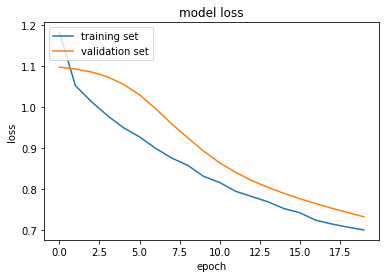

In [19]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [20]:
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [21]:
y_prob

array([[0.32066384, 0.30251092, 0.3768252 ],
       [0.19550692, 0.60613203, 0.19836102],
       [0.58568007, 0.14168061, 0.27263936],
       ...,
       [0.90023524, 0.02535851, 0.07440622],
       [0.20392887, 0.5328295 , 0.2632416 ],
       [0.3193608 , 0.29275116, 0.38788804]], dtype=float32)

In [22]:
y_test = test_generator.classes

In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.32      0.29      0.30       221
           1       0.27      0.28      0.27       188
           2       0.30      0.31      0.30       213

    accuracy                           0.29       622
   macro avg       0.29      0.29      0.29       622
weighted avg       0.30      0.29      0.29       622



**ResNet50**

In [24]:
model_resnet_nt = Sequential()

not_trained_model = ResNet50(input_shape=(224,224,3),
    include_top=False,
    pooling ='avg',
    weights=None)

model_resnet_nt.add(not_trained_model)
model_resnet_nt.add(Flatten())

model_resnet_nt.add(Dense(num_classes, activation = 'softmax'))

In [25]:
model_resnet_nt.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


In [26]:
sgd = SGD(learning_rate=0.00001)

model_resnet_nt.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine =model_resnet_nt.fit(train_generator,
                        epochs=10,
                        batch_size=32,
                        validation_data=valid_generator)

Epoch 1/10
65/65 [==============================] - 37s 471ms/step - loss: 2.1564 - accuracy: 0.3238 - val_loss: 1.1988 - val_accuracy: 0.3146
Epoch 2/10
65/65 [==============================] - 28s 424ms/step - loss: 1.5428 - accuracy: 0.3277 - val_loss: 1.2299 - val_accuracy: 0.3146
Epoch 3/10
65/65 [==============================] - 28s 429ms/step - loss: 1.1941 - accuracy: 0.3682 - val_loss: 1.2112 - val_accuracy: 0.3146
Epoch 4/10
65/65 [==============================] - 28s 428ms/step - loss: 1.0161 - accuracy: 0.4344 - val_loss: 1.2030 - val_accuracy: 0.3146
Epoch 5/10
65/65 [==============================] - 28s 428ms/step - loss: 0.9093 - accuracy: 0.5468 - val_loss: 1.1443 - val_accuracy: 0.3109
Epoch 6/10
65/65 [==============================] - 28s 431ms/step - loss: 0.8313 - accuracy: 0.6482 - val_loss: 1.1659 - val_accuracy: 0.3146
Epoch 7/10
65/65 [==============================] - 28s 434ms/step - loss: 0.7835 - accuracy: 0.6868 - val_loss: 1.0404 - val_accuracy: 0.5431

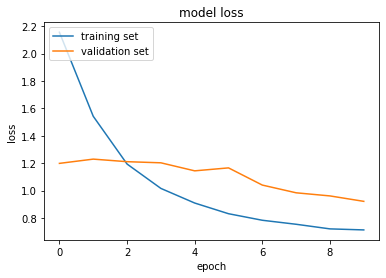

In [27]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [28]:
y_prob = model_resnet_nt.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [29]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.39      0.12      0.18       221
           1       0.33      0.25      0.28       188
           2       0.35      0.69      0.47       213

    accuracy                           0.35       622
   macro avg       0.36      0.35      0.31       622
weighted avg       0.36      0.35      0.31       622



**Transfer Learning ResNet50**

In [30]:
model_resnet_pt = Sequential()

pre_trained_model = ResNet50(input_shape=(224,224,3),
    include_top=False,
    pooling ='avg',
    weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

model_resnet_pt.add(pre_trained_model)
model_resnet_pt.add(Flatten())

model_resnet_pt.add(Dense(num_classes, activation = 'softmax'))

94781440/94765736 [==============================] - 2s 0us/step


In [31]:
model_resnet_pt.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [32]:
sgd = SGD(learning_rate=0.00002)

model_resnet_pt.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine =model_resnet_pt.fit(train_generator,
                        epochs=10,
                        batch_size=32,
                        validation_data=valid_generator)

Epoch 1/10
65/65 [==============================] - 16s 202ms/step - loss: 1.0742 - accuracy: 0.3596 - val_loss: 1.0501 - val_accuracy: 0.3670
Epoch 2/10
65/65 [==============================] - 12s 178ms/step - loss: 1.0335 - accuracy: 0.3938 - val_loss: 1.0228 - val_accuracy: 0.4007
Epoch 3/10
65/65 [==============================] - 13s 196ms/step - loss: 1.0157 - accuracy: 0.4440 - val_loss: 1.0095 - val_accuracy: 0.5768
Epoch 4/10
65/65 [==============================] - 12s 177ms/step - loss: 1.0068 - accuracy: 0.6173 - val_loss: 1.0019 - val_accuracy: 0.6854
Epoch 5/10
65/65 [==============================] - 12s 176ms/step - loss: 1.0013 - accuracy: 0.6704 - val_loss: 0.9968 - val_accuracy: 0.7116
Epoch 6/10
65/65 [==============================] - 12s 188ms/step - loss: 0.9972 - accuracy: 0.6815 - val_loss: 0.9926 - val_accuracy: 0.7116
Epoch 7/10
65/65 [==============================] - 12s 176ms/step - loss: 0.9936 - accuracy: 0.6882 - val_loss: 0.9888 - val_accuracy: 0.7079

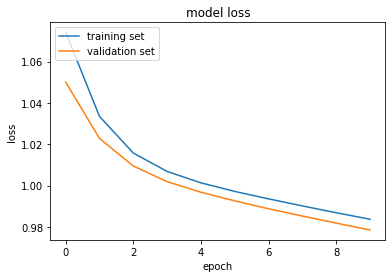

In [33]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [34]:
y_prob = model_resnet_pt.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.40      0.34      0.37       221
           1       0.30      0.38      0.34       188
           2       0.35      0.32      0.34       213

    accuracy                           0.35       622
   macro avg       0.35      0.35      0.35       622
weighted avg       0.35      0.35      0.35       622



Teste de ocr com tesseract

In [ ]:
dataset_dict['text'] = []

for folder in lista_subfolders:
  lista_imagens = os.listdir(path_documents+'/'+folder)
  for img_file in lista_imagens:
    dataset_dict['text'].append(pytesseract.image_to_string(Image.open(path_documents+'/'+folder+'/'+img_file)))